<a href="https://colab.research.google.com/github/taeyoonnoh/Kaggle-Competition/blob/main/Getting_Started/Titanic/Best_Titanic_with_Nueral_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic 

In [ ]:
# ! pip install -q kaggle

# from google.colab import files

# files.upload()

# ! mkdir ~/.kaggle

# ! cp kaggle.json ~/.kaggle/

# ! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# !kaggle competitions download -c titanic

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Check Data

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

full_df = pd.concat([train, test]).reset_index(drop=True)

train_shape = train.shape
test_shape = test.shape

train_shape,test_shape

((891, 12), (418, 11))

In [ ]:
print(full_df.shape)

(1309, 12)


In [ ]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [ ]:
full_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [ ]:
full_df[full_df['Survived'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
891,892,NaN,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
892,893,NaN,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
893,894,NaN,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
894,895,NaN,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
895,896,NaN,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


# Feature Engineering

# Sex Encoding

In [ ]:
full_df['Sex'] = (full_df['Sex']=='female').astype(int)

# Name 

In [ ]:
mapping = {'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs', 'Major': 'Other', 
           'Col': 'Other', 'Dr' : 'Other', 'Rev' : 'Other', 'Capt': 'Other', 
           'Jonkheer': 'Royal', 'Sir': 'Royal', 'Lady': 'Royal', 
           'Don': 'Royal', 'Countess': 'Royal', 'Dona': 'Royal'}

full_df['Title'] = full_df['Name'].apply(lambda x : x.split(',')[1].split('.')[0].strip())

# Replacing rare titles
full_df.replace({'Title':mapping},inplace=True)

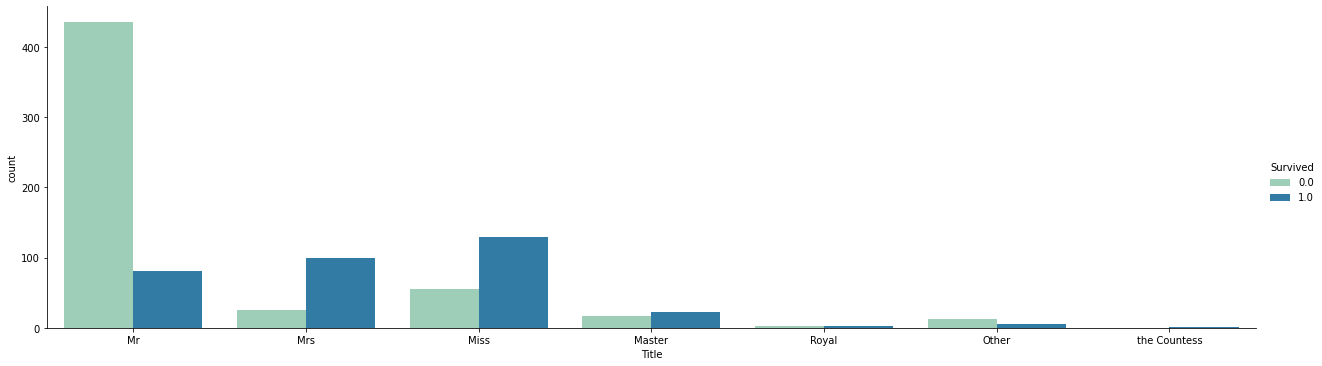

In [ ]:
c2 = sns.catplot(x="Title", hue="Survived", kind="count", data=full_df[:train_shape[0]],
                 aspect = 3.5, legend=True, palette="YlGnBu")

In [ ]:
# name length
full_df['Name_Length'] = full_df['Name'].str.replace('[^a-zA-Z]','').str.len()

# One-hot encode embarked & Label encode title

In [ ]:
full_df['Title_C'] = full_df['Title']

full_df = pd.get_dummies(full_df,columns=['Embarked','Title_C'],prefix=['Emb','Title'],drop_first=False)

title_dict = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Other': 4, 'Royal': 5, 'Master': 6}

full_df['Title'] = full_df['Title'].map(title_dict)

full_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title,Name_Length,Emb_C,Emb_Q,Emb_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Title_Royal,Title_the Countess
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,1.0,18,0,0,1,0,0,1,0,0,0,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,3.0,41,1,0,0,0,0,0,1,0,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2.0,18,0,0,1,0,1,0,0,0,0,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,3.0,34,0,0,1,0,0,0,1,0,0,0
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,1.0,19,0,0,1,0,0,1,0,0,0,0


## Family size

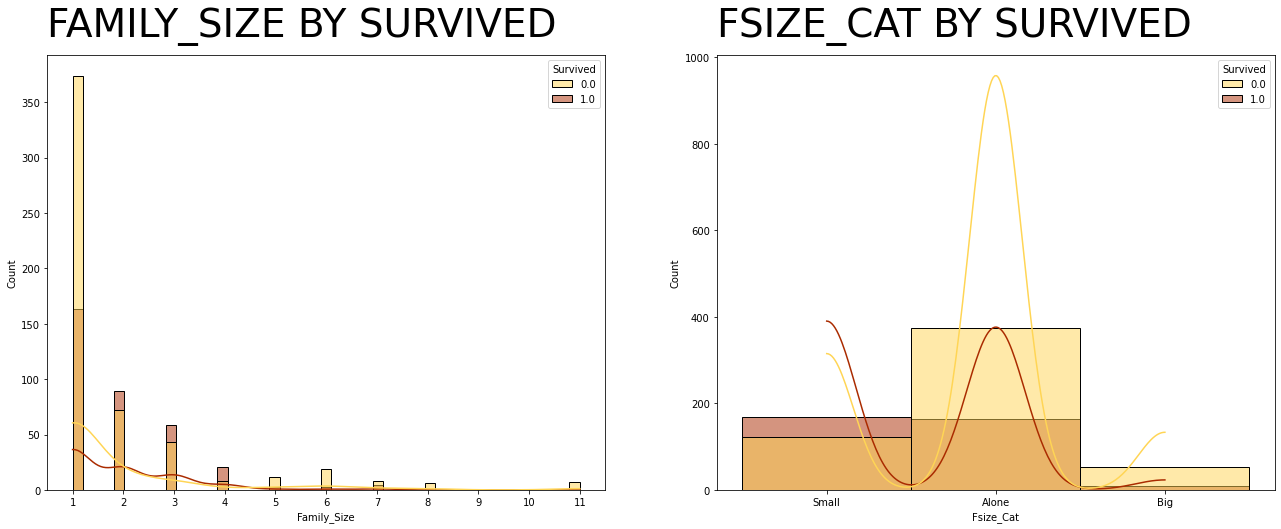

In [ ]:
# New feature : Family_size
full_df['Family_Size'] = full_df['Parch'] + full_df['SibSp'] + 1

full_df['Fsize_Cat'] = full_df['Family_Size'].map(lambda val: 'Alone' if val <= 1 else ('Small' if val < 5 else 'Big'))

fig, ax = plt.subplots(ncols=2, figsize=(22,8))
for i, col in enumerate(['Family_Size', 'Fsize_Cat']):
    sns.histplot(x=col, data=full_df[:train_shape[0]], hue="Survived", fill=True, ax=ax[i], palette="afmhot_r", kde=True)
    ax[i].set_title(col.upper()+" BY SURVIVED", x=0.0, y=1.03, ha='left',
         fontweight=200, fontfamily='Lato', size=39)
    if(col=='Family_Size'):
        ax[i].xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax[i].xaxis.set_major_formatter(ticker.ScalarFormatter())

In [ ]:
Fsize_dict = {'Alone':3, 'Small':2, 'Big':1}
full_df['Fsize_Cat'] = full_df['Fsize_Cat'].map(Fsize_dict).astype('int')

## Extract family name

In [ ]:
full_df['Family_Name'] = full_df['Name'].str.split(',',expand=True)[0]

## Derive Friends & Family Survival Rate Feature

This seems to be one of the key features that improves scores after a lot of submissions engineering different features each time.

If passengers with the same Last names are present, we group them and attach a calculated survival rate based on the train survival data.

For no matching last names, the Ticket feature is used to group and calculate the survival rate in the same way.

From the data, we see Tickets are given to groups travelling together and they all have the same Ticket number.

In [ ]:
MEAN_SURVIVAL_RATE = round(np.mean(train['Survived']), 4)

full_df['Family_Friends_Surv_Rate'] = MEAN_SURVIVAL_RATE
full_df['Surv_Rate_Invalid'] = 1

In [ ]:
for _, grp_df in full_df[['Survived', 'Family_Name', 'Fare', 'Ticket', 'PassengerId']].groupby(['Family_Name', 'Fare']):                       
    # 만약 가족 단위이면
    if (len(grp_df) > 1):
        # 모두 test data 에 있는 데이터가 아닐 경우
        if(grp_df['Survived'].isnull().sum() != len(grp_df)):
            for ind, row in grp_df.iterrows():
                # train data 의 가족 단위의 survival rate 로 update!
                full_df.loc[full_df['PassengerId'] == row['PassengerId'],
                            'Family_Friends_Surv_Rate'] = round(grp_df['Survived'].mean(), 4)
                full_df.loc[full_df['PassengerId'] == row['PassengerId'],
                            'Surv_Rate_Invalid'] = 0

for _, grp_df in full_df[['Survived', 'Family_Name', 'Fare', 'Ticket', 'PassengerId', 'Family_Friends_Surv_Rate']].groupby('Ticket'):
    # ticket으로 grouping 한 뒤 그룹 단위이면
    if (len(grp_df) > 1):
        for ind, row in grp_df.iterrows():
            # survival rate 가 0 이거나 0.368 이면
            if (row['Family_Friends_Surv_Rate'] == 0.) | (row['Family_Friends_Surv_Rate'] == MEAN_SURVIVAL_RATE):
                # 모두 test data 에 있는 데이터가 아닐 경우 
                if (grp_df['Survived'].isnull().sum() != len(grp_df)):
                    # train 의 ticket 단위의 survival rate 로 update!
                    full_df.loc[full_df['PassengerId'] == row['PassengerId'],
                                'Family_Friends_Surv_Rate'] = round(grp_df['Survived'].mean(), 4)
                    full_df.loc[full_df['PassengerId'] == row['PassengerId'],
                                'Surv_Rate_Invalid'] = 0

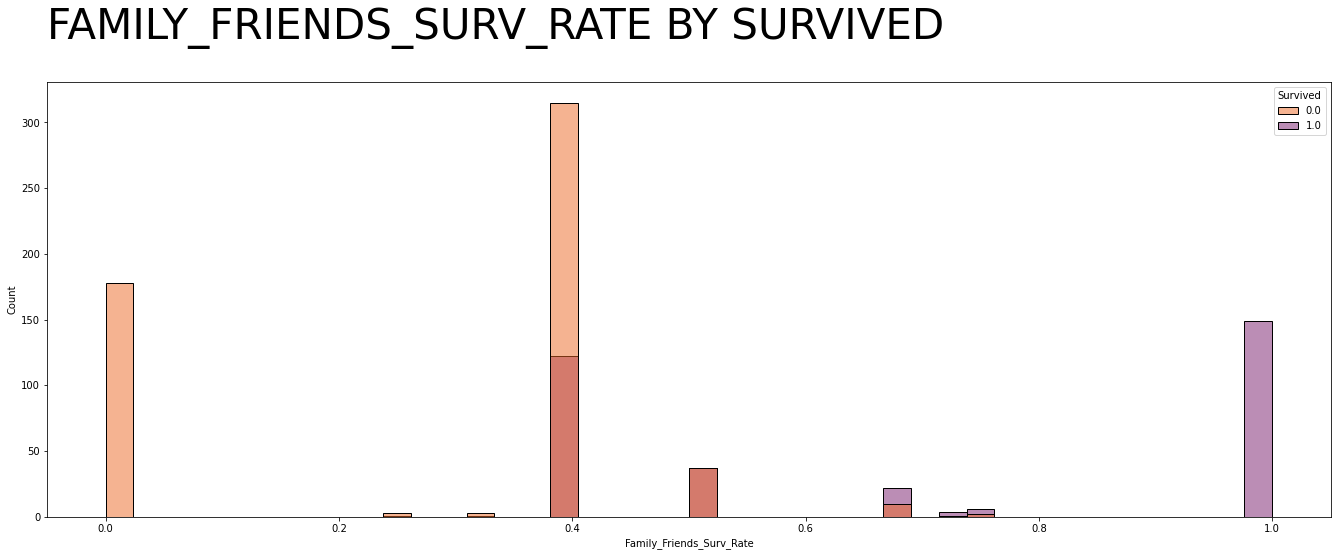

In [ ]:
fig, ax = plt.subplots(figsize=(23,8))
sns.histplot(x='Family_Friends_Surv_Rate', data=full_df[:train_shape[0]], hue="Survived", fill=True, ax=ax, palette="inferno_r")
fig.suptitle("FAMILY_FRIENDS_SURV_RATE BY SURVIVED", x=0.125, y=1.01, ha='left',
             fontweight=100, fontfamily='Lato', size=42);

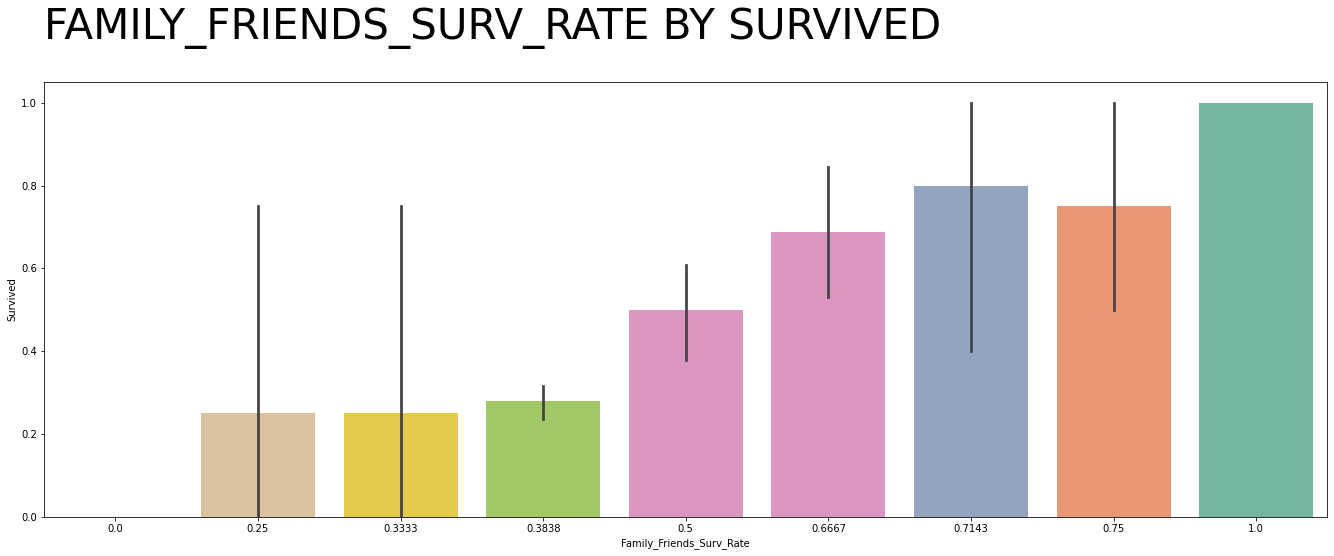

In [ ]:
fig, ax = plt.subplots(figsize=(23,8))
sns.barplot(y='Survived', x='Family_Friends_Surv_Rate', data=full_df[:train_shape[0]], ax=ax, palette="Set2_r")
fig.suptitle("FAMILY_FRIENDS_SURV_RATE BY SURVIVED", x=0.125, y=1.01, ha='left',
             fontweight=100, fontfamily='Lato', size=42);

## Cabin

In [ ]:
full_df['Cabin'] = full_df['Cabin'].astype('category')
full_df['Cabin'] = full_df['Cabin'].cat.add_categories('U')
full_df['Cabin_Clean'] = full_df['Cabin'].fillna('U')
full_df['Cabin_Clean'] = full_df['Cabin_Clean'].str.strip(' ').str[0]
# Label Encoding
cabin_dict = {'A':9, 'B':8, 'C':7, 'D':6, 'E':5, 'F':4, 'G':3, 'T':2, 'U':1}
full_df['Cabin_Clean'] = full_df['Cabin_Clean'].map(cabin_dict).astype('int')

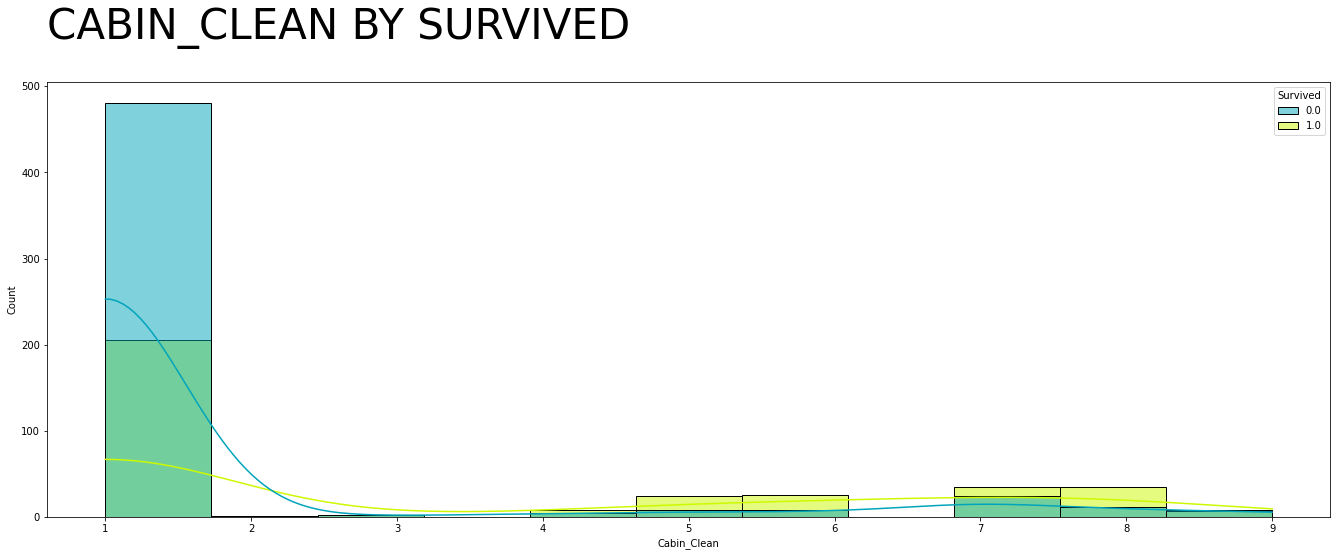

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(23,8))
sns.histplot(x="Cabin_Clean", data=full_df[:train_shape[0]], hue="Survived", fill=True, ax=ax, palette="nipy_spectral", kde=True)
fig.suptitle("CABIN_CLEAN BY SURVIVED", x=0.125, y=1.01, ha='left',
             fontweight=100, fontfamily='Lato', size=42);

## Cleaning Ticket

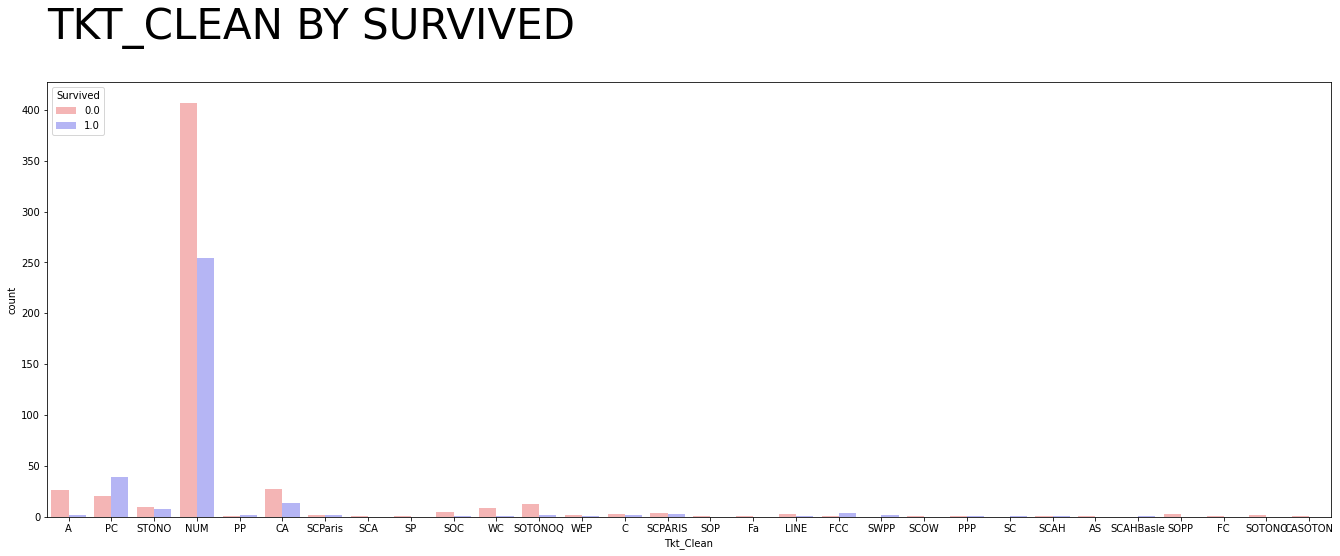

In [ ]:
import re
def clean_ticket(each_ticket):
    prefix = re.sub(r'[^a-zA-Z]', '', each_ticket)
    if(prefix):
        return prefix
    else:
        return "NUM"

full_df["Tkt_Clean"] = full_df.Ticket.apply(clean_ticket)

fig, ax = plt.subplots(ncols=1, figsize=(23,8))
sns.countplot(x="Tkt_Clean", data=full_df[:train_shape[0]], hue="Survived", fill=True, ax=ax, palette="bwr_r")
fig.suptitle("TKT_CLEAN BY SURVIVED", x=0.125, y=1.01, ha='left',
             fontweight=100, fontfamily='Lato', size=42);

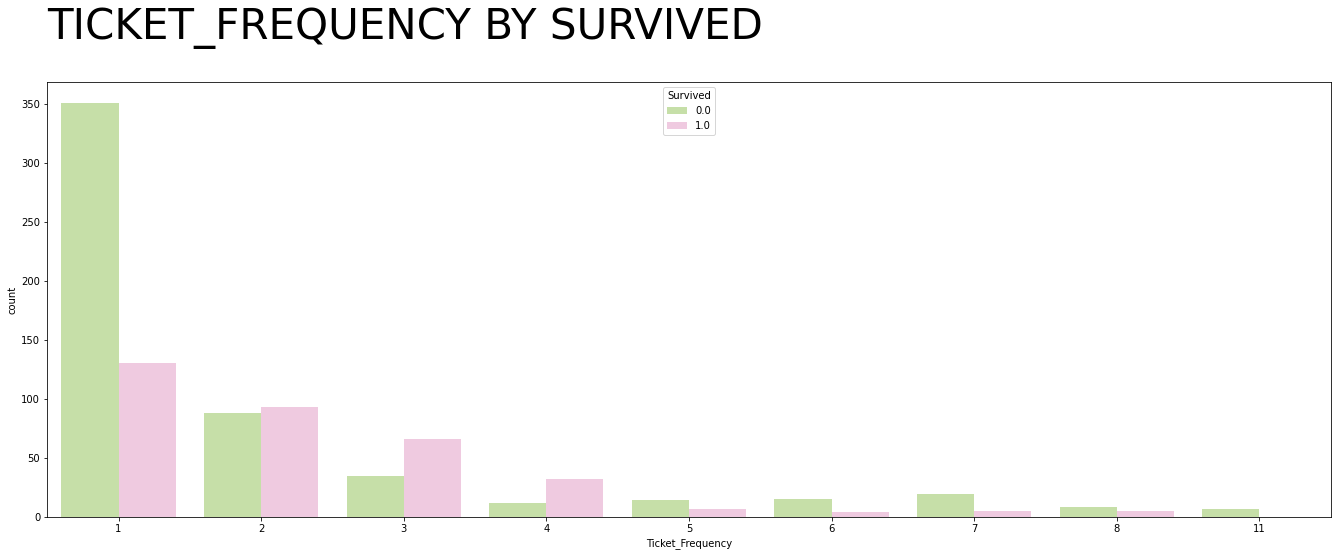

In [ ]:
full_df['Ticket_Frequency'] = full_df.groupby('Ticket')['Ticket'].transform('count')
fig, ax = plt.subplots(ncols=1, figsize=(23,8))
sns.countplot(x="Ticket_Frequency", data=full_df[:train_shape[0]], hue="Survived", fill=True, ax=ax, palette="PiYG_r")

fig.suptitle("TICKET_FREQUENCY BY SURVIVED", x=0.125, y=1.01, ha='left',
             fontweight=100, fontfamily='Lato', size=42);

In [ ]:
# one hot encoding ticket
full_df = pd.get_dummies(full_df, columns=["Tkt_Clean"],\
                          prefix=["Tkt"], drop_first=True)

# Fare into categorical bins

In [ ]:
def fare_cat(fare):
    if fare <= 7.0:
        return 1
    elif fare <= 39 and fare > 7.0:
        return 2
    else:
        return 3

full_df.loc[:, 'Fare_Cat'] = full_df['Fare'].apply(fare_cat).astype('int')

## Additional relationships

In [ ]:
full_df.loc[:, 'Fare_Family_Size'] = full_df['Fare']/full_df['Family_Size']

full_df.loc[:, 'Fare_Cat_Pclass'] = full_df['Fare_Cat']*full_df['Pclass']
full_df.loc[:, 'Fare_Cat_Title'] = full_df['Fare_Cat']*full_df['Title']

full_df.loc[:, 'Fsize_Cat_Title'] = full_df['Fsize_Cat']*full_df['Title']
full_df.loc[:, 'Fsize_Cat_Fare_Cat'] = full_df['Fare_Cat']/full_df['Fsize_Cat'].astype('int')

full_df.loc[:, 'Pclass_Title'] = full_df['Pclass']*full_df['Title']
full_df.loc[:, 'Fsize_Cat_Pclass'] = full_df['Fsize_Cat']*full_df['Pclass']

## remove constant columns

In [ ]:
full_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title,Name_Length,Emb_C,Emb_Q,Emb_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Title_Royal,Title_the Countess,Family_Size,Fsize_Cat,Family_Name,Family_Friends_Surv_Rate,Surv_Rate_Invalid,Cabin_Clean,Ticket_Frequency,Tkt_AQ,Tkt_AS,Tkt_C,Tkt_CA,Tkt_CASOTON,Tkt_FC,Tkt_FCC,Tkt_Fa,Tkt_LINE,Tkt_LP,Tkt_NUM,Tkt_PC,Tkt_PP,Tkt_PPP,Tkt_SC,Tkt_SCA,Tkt_SCAH,Tkt_SCAHBasle,Tkt_SCOW,Tkt_SCPARIS,Tkt_SCParis,Tkt_SOC,Tkt_SOP,Tkt_SOPP,Tkt_SOTONO,Tkt_SOTONOQ,Tkt_SP,Tkt_STONO,Tkt_STONOQ,Tkt_SWPP,Tkt_WC,Tkt_WEP,Fare_Cat,Fare_Family_Size,Fare_Cat_Pclass,Fare_Cat_Title,Fsize_Cat_Title,Fsize_Cat_Fare_Cat,Pclass_Title,Fsize_Cat_Pclass
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,1.0,18,0,0,1,0,0,1,0,0,0,0,2,2,Braund,0.3838,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3.62500,6,2.0,2.0,1.000000,3.0,6
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,3.0,41,1,0,0,0,0,0,1,0,0,0,2,2,Cumings,1.0000,0,7,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,35.64165,3,9.0,6.0,1.500000,3.0,2
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2.0,18,0,0,1,0,1,0,0,0,0,0,1,3,Heikkinen,0.3838,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,7.92500,6,4.0,6.0,0.666667,6.0,9
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,3.0,34,0,0,1,0,0,0,1,0,0,0,2,2,Futrelle,0.5000,0,7,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,26.55000,3,9.0,6.0,1.500000,3.0,2
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,1.0,19,0,0,1,0,0,1,0,0,0,0,1,3,Allen,0.3838,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8.05000,6,2.0,3.0,0.666667,3.0,9


In [ ]:
colsToRemove = []

cols = list(full_df.columns)
cols.remove('Name')
cols.remove('Ticket')
cols.remove('Cabin')
cols.remove('Family_Name')

for col in cols:
    if full_df[col][:train_shape[0]].std() == 0: 
        colsToRemove.append(col)

# remove constant columns in the training set
full_df.drop(colsToRemove, axis=1, inplace=True)
print("Removed `{}` Constant Columns\n".format(len(colsToRemove)))
print(colsToRemove)

Removed `3` Constant Columns

['Tkt_AQ', 'Tkt_LP', 'Tkt_STONOQ']


# Imputations

In [ ]:
from sklearn.impute import KNNImputer

In [ ]:
from sklearn.impute import KNNImputer
imp_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Title',
                 'Name_Length', 'Emb_C', 'Emb_Q', 'Emb_S','Family_Size',
                 'Fsize_Cat', 'Family_Friends_Surv_Rate', 'Surv_Rate_Invalid',
                 'Cabin_Clean','Ticket_Frequency', 'Tkt_AS', 'Tkt_C', 'Tkt_CA',
                 'Tkt_CASOTON', 'Tkt_FC', 'Tkt_FCC', 'Tkt_Fa', 'Tkt_LINE',
                 'Tkt_NUM', 'Tkt_PC', 'Tkt_PP', 'Tkt_PPP', 'Tkt_SC', 'Tkt_SCA',
                 'Tkt_SCAH', 'Tkt_SCAHBasle', 'Tkt_SCOW', 'Tkt_SCPARIS', 'Tkt_SCParis',
                 'Tkt_SOC', 'Tkt_SOP', 'Tkt_SOPP', 'Tkt_SOTONO', 'Tkt_SOTONOQ',
                 'Tkt_SP', 'Tkt_STONO', 'Tkt_SWPP', 'Tkt_WC', 
                 'Tkt_WEP', 'Fare_Cat', 'Fare_Family_Size', 'Fare_Cat_Pclass',
                 'Fare_Cat_Title', 'Fsize_Cat_Title', 'Fsize_Cat_Fare_Cat', 
                 'Pclass_Title', 'Fsize_Cat_Pclass']

imputer = KNNImputer(n_neighbors=10, missing_values=np.nan)
# full_df[imp_features] = pd.DataFrame(imputer.fit_transform(full_df[imp_features]), index=full_df.index, columns = imp_features)
imputer.fit(full_df[imp_features])

KNNImputer(add_indicator=False, copy=True, metric='nan_euclidean',
           missing_values=nan, n_neighbors=10, weights='uniform')

In [ ]:
full_df.loc[:, imp_features] = pd.DataFrame(imputer.transform(full_df[imp_features]), index=full_df.index, columns = imp_features)

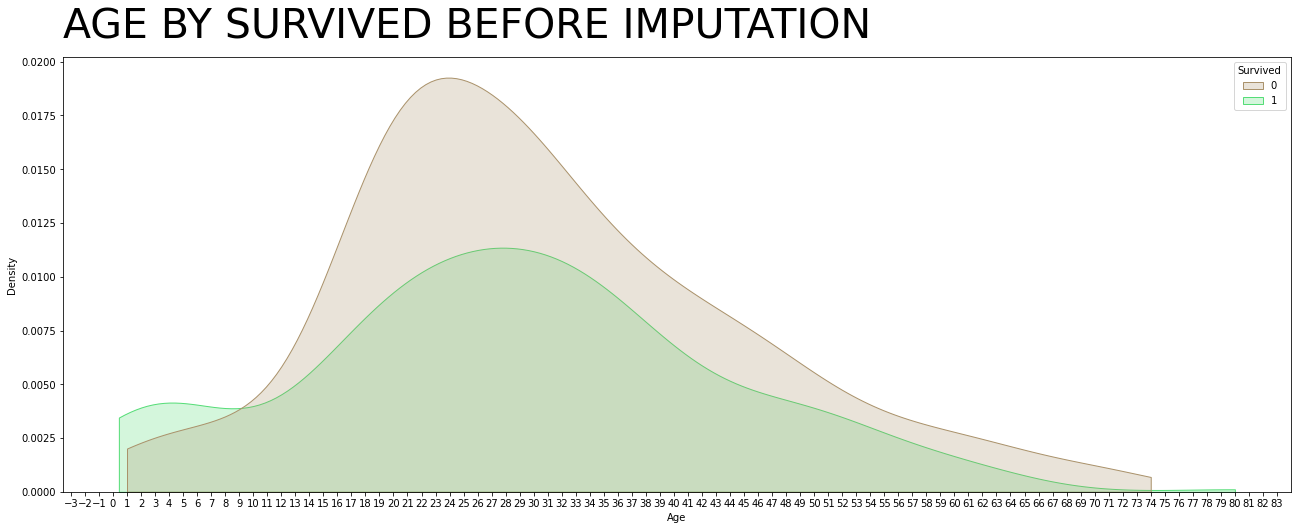

In [ ]:
plt.figure(figsize=(22,8))
kde = sns.kdeplot(x="Age", data=train, cut=0, hue="Survived", fill=True, legend=True, palette="terrain_r")
#kde.title.set_text("Age by Survived Before Imputation")
title = kde.set_title("AGE BY SURVIVED BEFORE IMPUTATION", x=0.0, y=1.03, ha='left',
             fontweight=100, fontfamily='Lato',
             size=41)

kde.xaxis.set_major_locator(ticker.MultipleLocator(1))
kde.xaxis.set_major_formatter(ticker.ScalarFormatter())

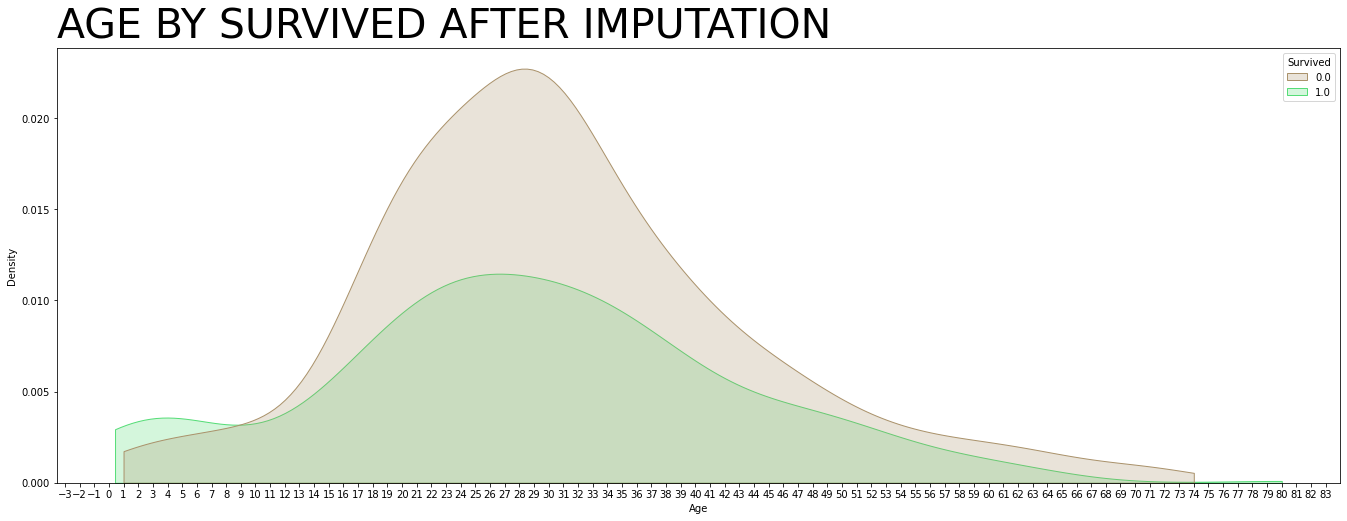

In [ ]:
plt.figure(figsize=(23,8))
kde = sns.kdeplot(x="Age", data=full_df[:train_shape[0]], cut=0, hue="Survived", fill=True, legend=True, palette="terrain_r")

title = kde.set_title("AGE BY SURVIVED AFTER IMPUTATION", x=0.0, y=1.01, ha='left',
             fontweight=100, fontfamily='Lato', size=41)

kde.xaxis.set_major_locator(ticker.MultipleLocator(1))
kde.xaxis.set_major_formatter(ticker.ScalarFormatter())

## Child and Senior

In [ ]:
full_df['Child'] = full_df['Age'].map(lambda val:1 if val<18 else 0)
full_df['Senior'] = full_df['Age'].map(lambda val:1 if val>70 else 0)

## Split back 

In [ ]:
df_train_final = full_df[:train_shape[0]]
df_test_final = full_df[train_shape[0]:]

In [ ]:
full_df.to_pickle("full_df")
df_train_final.to_pickle("df_train_final")
df_test_final.to_pickle("df_test_final")

## Standardscaler

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler_cols = ['Age', 'Fare', 'Name_Length', 'Family_Size', 'Name_Length',
               'Ticket_Frequency', 'Fare_Family_Size', 'Fare_Cat_Pclass']
std = StandardScaler()
std.fit(df_train_final[scaler_cols])
df_train_final.loc[:, scaler_cols] = pd.DataFrame(std.transform(df_train_final[scaler_cols]), index=df_train_final.index, columns = scaler_cols)
df_test_final.loc[:, scaler_cols] = pd.DataFrame(std.transform(df_test_final[scaler_cols]), index=df_test_final.index, columns = scaler_cols)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


In [ ]:
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Title', 'Name_Length', 'Emb_C',
       'Emb_Q', 'Emb_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Other', 'Title_Royal', 'Family_Size', 'Fsize_Cat',
       'Family_Friends_Surv_Rate', 'Surv_Rate_Invalid', 'Cabin_Clean',
       'Ticket_Frequency', 'Tkt_AS', 'Tkt_C', 'Tkt_CA',
       'Tkt_CASOTON', 'Tkt_FC', 'Tkt_FCC', 'Tkt_Fa', 'Tkt_LINE', 
       'Tkt_NUM', 'Tkt_PC', 'Tkt_PP', 'Tkt_PPP', 'Tkt_SC', 'Tkt_SCA',
       'Tkt_SCAH', 'Tkt_SCAHBasle', 'Tkt_SCOW', 'Tkt_SCPARIS', 'Tkt_SCParis',
       'Tkt_SOC', 'Tkt_SOP', 'Tkt_SOPP', 'Tkt_SOTONO', 'Tkt_SOTONOQ', 'Tkt_SP',
       'Tkt_STONO', 'Tkt_SWPP', 'Tkt_WC', 'Tkt_WEP', 'Fare_Cat',
       'Fare_Family_Size', 'Fare_Cat_Pclass', 'Fare_Cat_Title',
       'Fsize_Cat_Title', 'Fsize_Cat_Fare_Cat', 'Pclass_Title',
       'Fsize_Cat_Pclass', 'Child', 'Senior']
features_train = ['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Title', 'Name_Length', 'Emb_C',
       'Emb_Q', 'Emb_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Other', 'Title_Royal', 'Family_Size', 'Fsize_Cat',
       'Family_Friends_Surv_Rate', 'Surv_Rate_Invalid', 'Cabin_Clean',
       'Ticket_Frequency', 'Tkt_AS', 'Tkt_C', 'Tkt_CA',
       'Tkt_CASOTON', 'Tkt_FC', 'Tkt_FCC', 'Tkt_Fa', 'Tkt_LINE',
       'Tkt_NUM', 'Tkt_PC', 'Tkt_PP', 'Tkt_PPP', 'Tkt_SC', 'Tkt_SCA',
       'Tkt_SCAH', 'Tkt_SCAHBasle', 'Tkt_SCOW', 'Tkt_SCPARIS', 'Tkt_SCParis',
       'Tkt_SOC', 'Tkt_SOP', 'Tkt_SOPP', 'Tkt_SOTONO', 'Tkt_SOTONOQ', 'Tkt_SP',
       'Tkt_STONO', 'Tkt_SWPP', 'Tkt_WC', 'Tkt_WEP', 'Fare_Cat',
       'Fare_Family_Size', 'Fare_Cat_Pclass', 'Fare_Cat_Title',
       'Fsize_Cat_Title', 'Fsize_Cat_Fare_Cat', 'Pclass_Title',
       'Fsize_Cat_Pclass', 'Child', 'Senior']

df_train_final = df_train_final[features_train]
df_test_final = df_test_final[features]

In [ ]:
corr_mat = df_train_final.astype(float).corr()
corr_mat_fil = corr_mat.loc[:, 'Survived'].sort_values(ascending=False)
corr_mat_fil = pd.DataFrame(data=corr_mat_fil[1:])

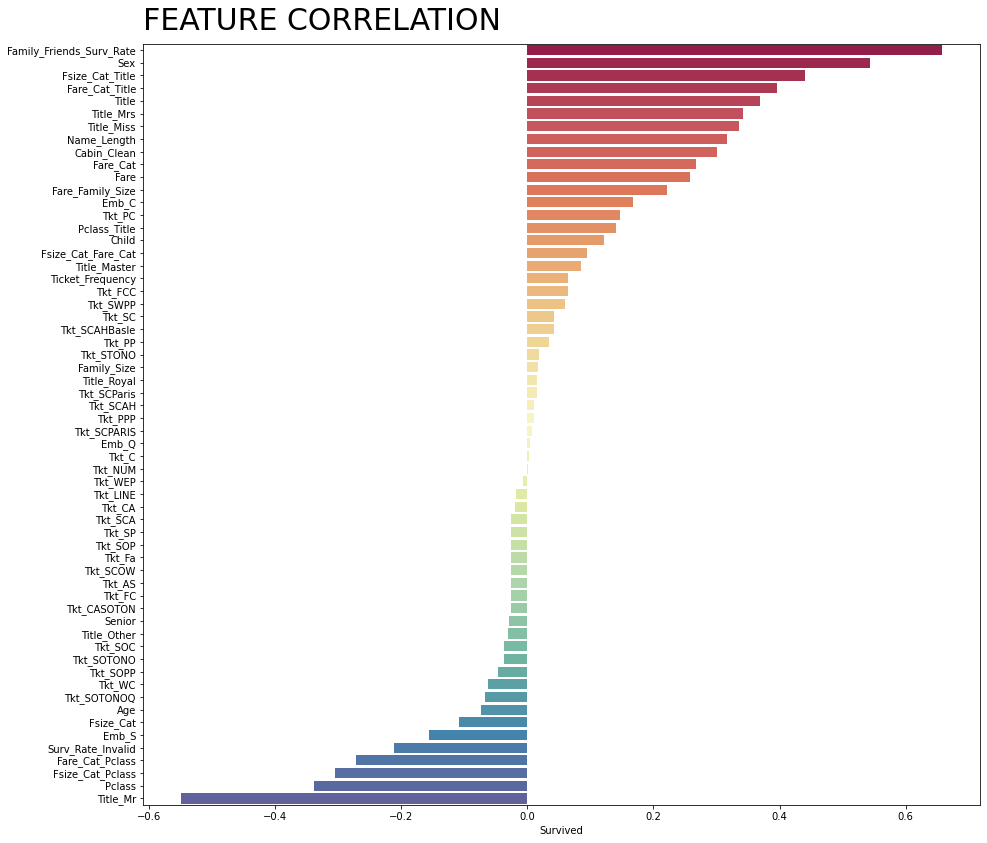

In [ ]:
plt.figure(figsize=(15,14))
bar = sns.barplot(x=corr_mat_fil.Survived, y=corr_mat_fil.index, data=corr_mat_fil, palette="Spectral")
title = bar.set_title("FEATURE CORRELATION", x=0.0, y=1.01, ha='left',
             fontweight=100, fontfamily='Lato', size=30)

In [ ]:
features = df_test_final.columns.to_list()
X_train = df_train_final[features]
Y_train = df_train_final['Survived']
X_test = df_test_final

## NN network

In [ ]:
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Dropout, AlphaDropout, BatchNormalization,Concatenate, concatenate
from tensorflow.keras.optimizers import SGD, RMSprop, Adamax, Adagrad, Adam, Nadam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import *

In [ ]:
metrics = ['accuracy', 
           Precision(),
           Recall()]

In [ ]:
def create_model():
    model = Sequential()
    model.add(Input(shape=X_train.shape[1], name='Input_'))
    model.add(Dense(8, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=l2(0.001)))
    model.add(Dense(16, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))

    model.summary()
    optimize = Adam(lr = 0.0001)
    model.compile(optimizer = optimize, 
                       loss = 'binary_crossentropy', 
                       metrics = metrics)
    return model

In [ ]:
estimator = KerasClassifier(build_fn = create_model, epochs = 600, batch_size = 32, verbose = 1)
kfold = StratifiedKFold(n_splits = 3)
results = cross_val_score(estimator, X_train, Y_train, cv = kfold)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 488       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                144       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 921
Trainable params: 921
Non-trainable params: 0
__________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/600
19/19 [==============================] - 1s 2ms/step - loss: 3.2957 - accuracy: 0.5253 - precision: 0.3702 - recall: 0.3377
Epoch 2/600
19/19 [==============================] - 0s 2ms/step - loss: 3.2350 - accuracy: 0.5387 - precision: 0.3802 - recall: 0.3202
Epoch 3/600
19/19 [==============================] - 0s 2ms/step - loss: 3.1989 - accuracy: 0.5505 - precision: 0.4126 - recall: 0.4035
Epoch 4/600
19/19 [==============================] - 0s 2ms/step - loss: 3.1500 - accuracy: 0.5842 - precision: 0.4451 - recall: 0.3377
Epoch 5/600
19/19 [==============================] - 0s 2ms/step - loss: 3.1221 - accuracy: 0.5640 - precision: 0.4205 - recall: 0.3596
Epoch 6/600
19/19 [==============================] - 0s 2ms/step - loss: 3.1087 - accuracy: 0.5471 - precision: 0.4000 - recall: 0.3596
Epoch 7/600
19/19 [==============================] - 0s 2ms/step - loss: 3.0757 - accuracy: 0.5556 - precision: 0.4091 - recall: 0.3553
Epoch 8/600
19/19 [=============================

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 1s 2ms/step - loss: 3.6009 - accuracy: 0.4747 - precision: 0.4704 - recall: 0.5117
Epoch 2/600
19/19 [==============================] - 0s 2ms/step - loss: 3.5520 - accuracy: 0.4646 - precision: 0.3381 - recall: 0.4123
Epoch 3/600
19/19 [==============================] - 0s 2ms/step - loss: 3.4667 - accuracy: 0.5101 - precision: 0.3811 - recall: 0.4430
Epoch 4/600
19/19 [==============================] - 0s 2ms/step - loss: 3.4280 - accuracy: 0.5135 - precision: 0.3822 - recall: 0.4342
Epoch 5/600
19/19 [==============================] - 0s 2ms/step - loss: 3.3952 - accuracy: 0.5051 - precision: 0.3690 - recall: 0.4079
Epoch 6/600
19/19 [==============================] - 0s 2ms/step - loss: 3.4010 - accuracy: 0.5202 - precision: 0.3916 - recall: 0.4518
Epoch 7/600
19/19 [==============================] - 0s 2ms/step - loss: 3.3411 - accuracy: 0.5185 - precision: 0.3849 - recall: 0.4254
Epoch 8/600
19/19 [==============================] - 0s 2ms/

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 1s 2ms/step - loss: 3.6123 - accuracy: 0.5825 - precision: 0.5758 - recall: 0.5994
Epoch 2/600
19/19 [==============================] - 0s 2ms/step - loss: 3.6134 - accuracy: 0.5606 - precision: 0.4310 - recall: 0.4518
Epoch 3/600
19/19 [==============================] - 0s 2ms/step - loss: 3.5826 - accuracy: 0.5421 - precision: 0.4113 - recall: 0.4474
Epoch 4/600
19/19 [==============================] - 0s 2ms/step - loss: 3.4963 - accuracy: 0.5404 - precision: 0.4104 - recall: 0.4518
Epoch 5/600
19/19 [==============================] - 0s 2ms/step - loss: 3.5016 - accuracy: 0.5690 - precision: 0.4426 - recall: 0.4737
Epoch 6/600
19/19 [==============================] - 0s 2ms/step - loss: 3.4300 - accuracy: 0.5993 - precision: 0.4786 - recall: 0.4912
Epoch 7/600
19/19 [==============================] - 0s 2ms/step - loss: 3.4590 - accuracy: 0.5269 - precision: 0.3944 - recall: 0.4342
Epoch 8/600
19/19 [==============================] - 0s 2ms/

In [ ]:
train_history = estimator.fit(X_train, Y_train, epochs = 600, batch_size = 32)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 8)                 488       
_________________________________________________________________
dense_13 (Dense)             (None, 16)                144       
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 921
Trainable params: 921
Non-trainable params: 0
________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


28/28 [==============================] - 1s 1ms/step - loss: 4.3567 - accuracy: 0.5230 - precision: 0.4891 - recall: 0.5417
Epoch 2/600
28/28 [==============================] - 0s 2ms/step - loss: 4.2031 - accuracy: 0.5095 - precision: 0.3913 - recall: 0.5000
Epoch 3/600
28/28 [==============================] - 0s 2ms/step - loss: 4.1915 - accuracy: 0.5118 - precision: 0.3906 - recall: 0.4854
Epoch 4/600
28/28 [==============================] - 0s 2ms/step - loss: 4.0655 - accuracy: 0.4983 - precision: 0.3804 - recall: 0.4883
Epoch 5/600
28/28 [==============================] - 0s 2ms/step - loss: 3.8769 - accuracy: 0.5387 - precision: 0.4090 - recall: 0.4532
Epoch 6/600
28/28 [==============================] - 0s 2ms/step - loss: 3.7690 - accuracy: 0.5544 - precision: 0.4307 - recall: 0.5000
Epoch 7/600
28/28 [==============================] - 0s 2ms/step - loss: 3.8070 - accuracy: 0.5196 - precision: 0.3946 - recall: 0.4708
Epoch 8/600
28/28 [==============================] - 0s 2ms/

In [ ]:
print(train_history.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall'])


findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


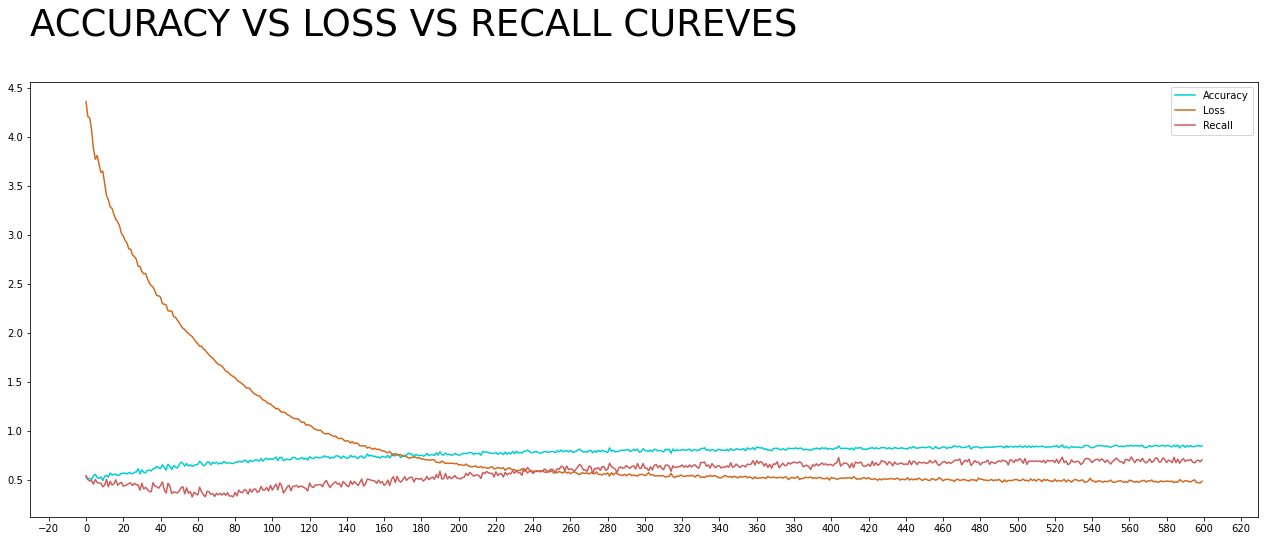

In [ ]:
fig = plt.figure(figsize=(22,8))
hist = sns.lineplot(data=train_history.history['accuracy'], color="darkturquoise", label='Accuracy')
hist = sns.lineplot(data=train_history.history['loss'], color="chocolate", label='Loss')
hist = sns.lineplot(data=train_history.history['recall'], color="indianred", label='Recall')

title = fig.suptitle("ACCURACY VS LOSS VS RECALL CUREVES", x=0.125, y=1.01, ha='left',
             fontweight=100, fontfamily='Lato', size=37)

hist.xaxis.set_major_locator(ticker.MultipleLocator(20))
hist.xaxis.set_major_formatter(ticker.ScalarFormatter())

plt.legend()
plt.show()

In [ ]:
y_preds = estimator.predict(X_test)
submission = pd.read_csv("gender_submission.csv", index_col='PassengerId')
submission['Survived'] = y_preds.astype(int)
submission.to_csv('submission.csv')

14/14 [==============================] - 0s 1ms/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
!kaggle competitions submit -c titanic -f submission.csv -m "2021-08-02 first commit - NN model"

100% 2.77k/2.77k [00:05<00:00, 504B/s]
Successfully submitted to Titanic - Machine Learning from Disaster